In [0]:
import torch as tc
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision 
import torchvision.transforms as transforms 
import matplotlib.pyplot as plt
import time
import pandas as pd
import numpy as np

In [486]:
device = tc.device("cuda:0" if (tc.cuda.is_available()) else "cpu")
device

device(type='cuda', index=0)

In [0]:
batch_size = 100
transform = transforms.Compose([
                transforms.ToTensor()])
mnist = torchvision.datasets.MNIST(root='./data/',
                                   train=True,
                                   transform=transform,
                                   download=True)

# Data loader
data_loader = tc.utils.data.DataLoader(dataset=mnist,
                                          batch_size=batch_size, 
                                          shuffle=True)

In [0]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.deconv2 = nn.ConvTranspose2d(100, 512, 4, 1, 0)
        self.deconv2_bn = nn.BatchNorm2d(512)
        self.deconv3 = nn.ConvTranspose2d(512, 256, 4, 2, 1)
        self.deconv3_bn = nn.BatchNorm2d(256)
        self.deconv4 = nn.ConvTranspose2d(256, 128, 4, 2, 1)
        self.deconv4_bn = nn.BatchNorm2d(128)
        self.deconv5 = nn.ConvTranspose2d(128, 1, 4, 2, 1)
   
    def forward(self, input):
        x = F.relu(self.deconv2_bn(self.deconv2(input)))
        x = F.relu(self.deconv3_bn(self.deconv3(x)))
        x = F.relu(self.deconv4_bn(self.deconv4(x)))
        x = F.tanh(self.deconv5(x))
        return x

In [0]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(1, 128, 4, 2, 1)
        self.conv2 = nn.Conv2d(128, 256, 4, 2, 1)
        self.conv2_bn = nn.BatchNorm2d(256)
        self.conv3 = nn.Conv2d(256, 512, 4, 2, 1)
        self.conv3_bn = nn.BatchNorm2d(512)
        self.conv5 = nn.Conv2d(512, 1, 4, 1, 0)
    def forward(self, input):
        x = F.leaky_relu(self.conv1(input), 0.2)
        x = F.leaky_relu(self.conv2_bn(self.conv2(x)), 0.2)
        x = F.leaky_relu(self.conv3_bn(self.conv3(x)), 0.2)
        x = F.sigmoid(self.conv5(x))
        return x

In [0]:
z_dim = 100
G = Generator().to(device)
D = Discriminator().to(device)

In [0]:
# loss
criterion = nn.BCELoss() 
def cost_G(output_G):
    return tc.mean(-tc.log(D(output_G)))

# optimizer
lr = 0.0002 
optimizer_G = optim.Adam(G.parameters(), lr = lr)
optimizer_D = optim.Adam(D.parameters(), lr = lr)

costs_G = []
costs_D = []

In [0]:
for epoch in range(50):
  tic = time.time()
  for i,data in enumerate(data_loader):
    # Training the Discriminator
    
    D.zero_grad()
    # Getting images from the training set
    x,_ = data
    # The images from the dataset are 28X28. We convert them to 32X32 images by padding.
    # Also, the pixel intensities range from 0 to 1. We make them range from -1 to 1
    x_real = tc.ones(batch_size,1,32,32).to(device)*(-1)
    x_real[:,:,2:30,2:30] = x*2 - 1
    # Calculating Discriminator output for images from the dataset. The label for images from the dataset is 1
    output_D = D(x_real)
    labels = tc.ones(batch_size).to(device)
    # Calculating Discriminator loss for images from the dataset
    real_loss = criterion(output_D[:,0,0,0],labels)
    
    # Images Generated by Generator
    z = tc.randn(batch_sizee,z_dim,1,1).to(device)
    x_fake = G(z)
    # Calculating Discriminator output for images generated by the Genearator. The label for images generated by the Generator is 0
    output_D = D(x_fake)
    labels = tc.zeros(batch_size).to(device)
    # Calculating Discriminator loss for images generated by the Genearator
    fake_loss = criterion(output_D,labels)
    
    # Calculating the total Discrimantor loss
    loss_D = real_loss + fake_loss
    costs_D.append(loss_D)
    print(i,'\t',loss_D.item())
    loss_D.backward()
    optimizer_D.step()
    
    # Training the Generator
   
    G.zero_grad()
    # Images Generated by Generator
    z = tc.randn(batch_size, z_dim,1,1).to(device)
    output_G = G(z)
    # Calculating Generator loss
    loss_G = cost_G(output_G)
    costs_G.append(loss_G)
    loss_G.backward()
    optimizer_G.step()
  toc = time.time()
  print(toc - tic)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1374: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


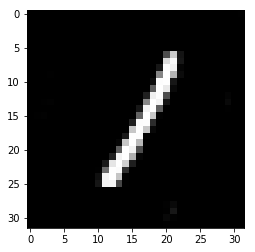

In [467]:
z = tc.randn(batch_size,z_dim,1,1).to(device)
plt.imshow(G(z)[0,0].detach().cpu(),cmap = 'gray')

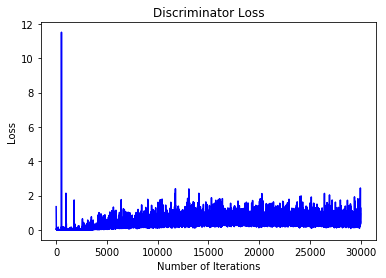

In [482]:
plt.plot(costs_G,'b',label = 'Generator Loss')
plt.plot(costs_D,'r',label = 'Discriminator Loss')
plt.xlabel('Number of Iterations')
plt.ylabel('Loss')
plt.title('Generator and Discriminator Loss')
plt.legend()
plt.savefig('plot1.png')

In [0]:
tc.save(G.state_dict(), 'G.pth')
tc.save(D.state_dict(), 'D.pth')
from google.colab import files
files.download('G.pth') 
files.download('D.pth')